# Stitching
Questions 2.1.1 - 2.2.4

2.1.1 Compute SIFT keypoints and corresponding descriptors for images 1Hill
and 2Hill. (3 points)

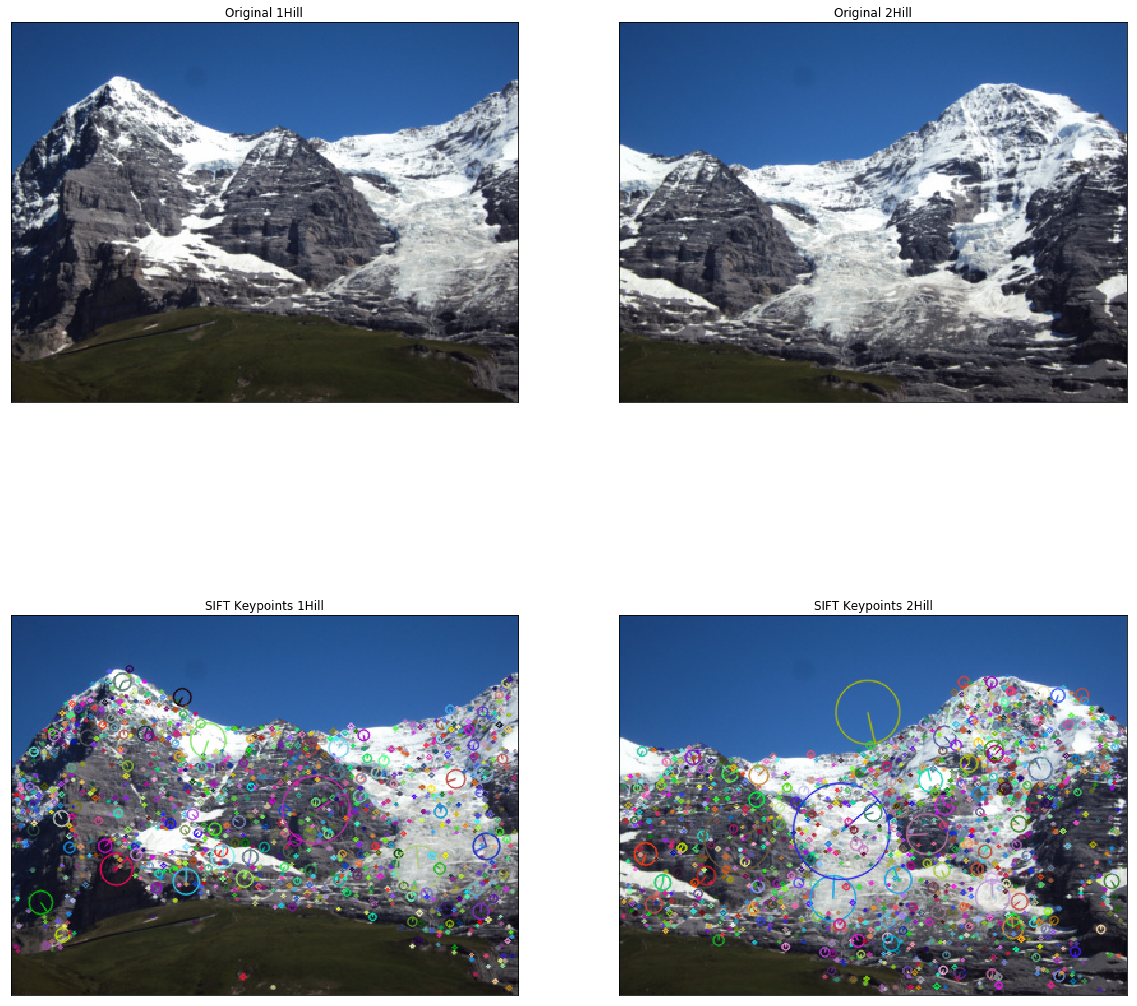

Time for SIFT on img1: 0.05484914779663086
Time for SIFT on img2: 0.05684852600097656
Number of features 1: 1248
Number of features 2: 1456


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

img1Hill = cv2.imread("./stitching_images/1Hill.JPG")
img2Hill = cv2.imread("./stitching_images/2Hill.JPG")
img3Hill = cv2.imread("./stitching_images/3Hill.JPG")

# Convert to RGB
img1Hill = cv2.cvtColor(img1Hill,cv2.COLOR_BGR2RGB)
img2Hill = cv2.cvtColor(img2Hill,cv2.COLOR_BGR2RGB)
img3Hill = cv2.cvtColor(img3Hill,cv2.COLOR_BGR2RGB)

#Remove white border of image
crop = 1
img1Hill = img1Hill[crop:img1Hill.shape[0]-crop, crop:img1Hill.shape[1]-crop]
img2Hill = img2Hill[crop:img2Hill.shape[0]-crop, crop:img2Hill.shape[1]-crop]
img3Hill = img3Hill[crop:img3Hill.shape[0]-crop, crop:img3Hill.shape[1]-crop]

# Compute SIFT Keypoints in each image
sift = cv2.xfeatures2d.SIFT_create()

# detect SIFT features, with no masks
t0 = time.time()
kpts1Hill, desc1Hill = sift.detectAndCompute(img1Hill, None)
t1 = time.time()
kpts2Hill, desc2Hill = sift.detectAndCompute(img2Hill, None)
t2 = time.time()

# Draw sift features to images
imgDisp1 = img1Hill.copy()
imgDisp2 = img2Hill.copy()

cv2.drawKeypoints(imgDisp1, kpts1Hill, imgDisp1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(imgDisp2, kpts2Hill, imgDisp2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Draw images
images = [ img1Hill, img2Hill, imgDisp1,imgDisp2,]
titles = ["Original 1Hill","Original 2Hill","SIFT Keypoints 1Hill", "SIFT Keypoints 2Hill"]

plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

print("Time for SIFT on img1:", t1-t0)
print("Time for SIFT on img2:", t2-t1)
print("Number of features 1:", str(len(kpts1Hill)))
print("Number of features 2:", str(len(kpts2Hill)))

2.1.2 Find matching keypoints in two images and display the 20 best pairs. (4
points)

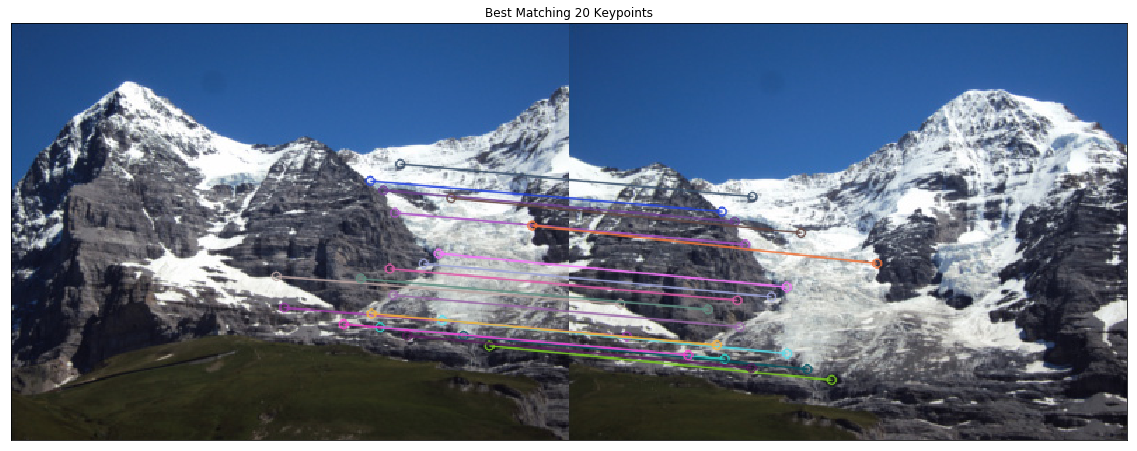

In [9]:
# Find matching keypoints in both images

img1Hill = cv2.imread("./stitching_images/1Hill.JPG")
img2Hill = cv2.imread("./stitching_images/2Hill.JPG")
img3Hill = cv2.imread("./stitching_images/3Hill.JPG")

img1Hill = cv2.cvtColor(img1Hill,cv2.COLOR_BGR2RGB)
img2Hill = cv2.cvtColor(img2Hill,cv2.COLOR_BGR2RGB)
img3Hill = cv2.cvtColor(img3Hill,cv2.COLOR_BGR2RGB)

#Remove white border of image
crop = 1
img1Hill = img1Hill[crop:img1Hill.shape[0]-crop, crop:img1Hill.shape[1]-crop]
img2Hill = img2Hill[crop:img2Hill.shape[0]-crop, crop:img2Hill.shape[1]-crop]
img3Hill = img3Hill[crop:img3Hill.shape[0]-crop, crop:img3Hill.shape[1]-crop]


# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(desc1Hill,desc2Hill)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 20 matches.
matchingImage = cv2.drawMatches(img1Hill,kpts1Hill,img2Hill,kpts2Hill, matches[:20], img1Hill, flags=2)

# display matching image
plt.figure(figsize=(20,20))
plt.imshow(matchingImage)
plt.title("Best Matching 20 Keypoints")
plt.xticks([]),plt.yticks([])
plt.show()

2.1.3 Find homography using RANSAC method and apply transformation to
1Hill. Image 2Hill should not be transformed. (7 points)

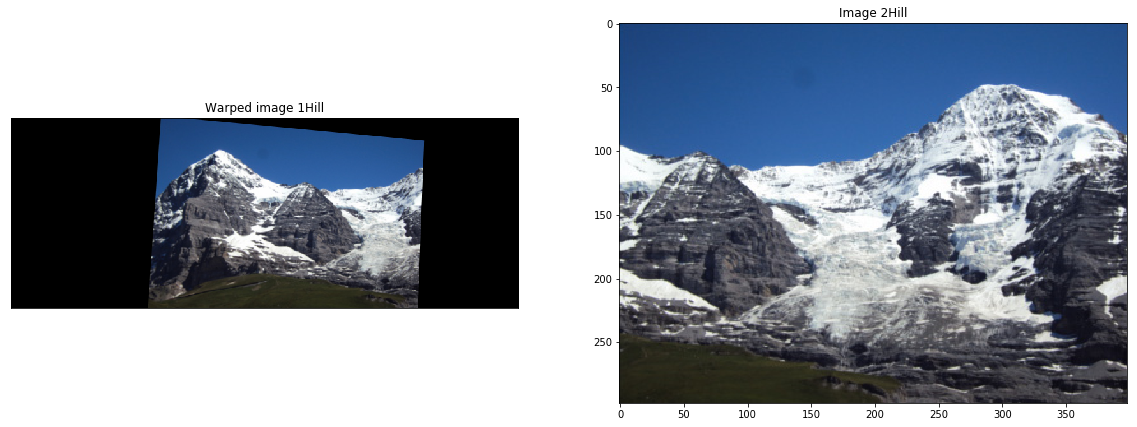

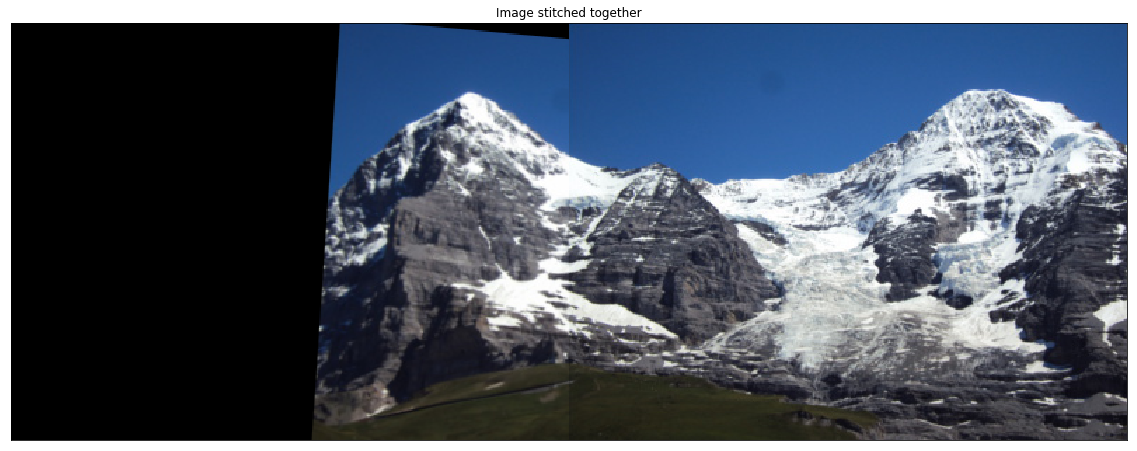

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img1Hill = cv2.imread("./stitching_images/1Hill.JPG")
img2Hill = cv2.imread("./stitching_images/2Hill.JPG")
img3Hill = cv2.imread("./stitching_images/3Hill.JPG")

img1Hill = cv2.cvtColor(img1Hill,cv2.COLOR_BGR2RGB)
img2Hill = cv2.cvtColor(img2Hill,cv2.COLOR_BGR2RGB)
img3Hill = cv2.cvtColor(img3Hill,cv2.COLOR_BGR2RGB)

#Remove white border of image
crop = 1
img1Hill = img1Hill[crop:img1Hill.shape[0]-crop, crop:img1Hill.shape[1]-crop]
img2Hill = img2Hill[crop:img2Hill.shape[0]-crop, crop:img2Hill.shape[1]-crop]
img3Hill = img3Hill[crop:img3Hill.shape[0]-crop, crop:img3Hill.shape[1]-crop]


# create BFMatcher object
bf = cv2.BFMatcher()#cv2.NORM_HAMMING, crossCheck=True)
# Find homography in img1Hill
# Match descriptors again and sort them.
matches = bf.match(desc1Hill,desc2Hill)
matches = sorted(matches, key = lambda x:x.distance)

# place good matches in an array together, side by side
# queryIdx matches with desc1Hill, trainIdx matches with desc2 hill
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

# Separate matches into their own 1d array for each image
matchesHill2 = np.float32([kpts2Hill[i].pt for (i, __) in GoodMatches])
matchesHill1 = np.float32([kpts1Hill[i].pt for (__, i) in GoodMatches])

for i in range(len(matchesHill2)):
    matchesHill2[i][0] += img2Hill.shape[1]

# Compute homography using the RANSAC method
Homography, mask = cv2.findHomography(matchesHill1,matchesHill2, cv2.RANSAC, 4)

# Apply homography to image 1 to warp its perspective to img2's
warpedImage = cv2.warpPerspective(img1Hill, Homography,(img1Hill.shape[1]+img2Hill.shape[1],img1Hill.shape[0]))

appendImage = warpedImage.copy()

warpedImage[:,img1Hill.shape[1]:,:] = img2Hill


#appendImage[:,img1Hill.shape[1]:,:] = img2Hill

# display stitched image image
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(appendImage)
plt.title("Warped image 1Hill")
plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(img2Hill)
plt.title("Image 2Hill")
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(warpedImage)
plt.title("Image stitched together")
plt.xticks([]),plt.yticks([])
plt.show()

2.1.4 Stitch transformed 1Hill and original 2Hill together using pyramid image blending. (8 points)

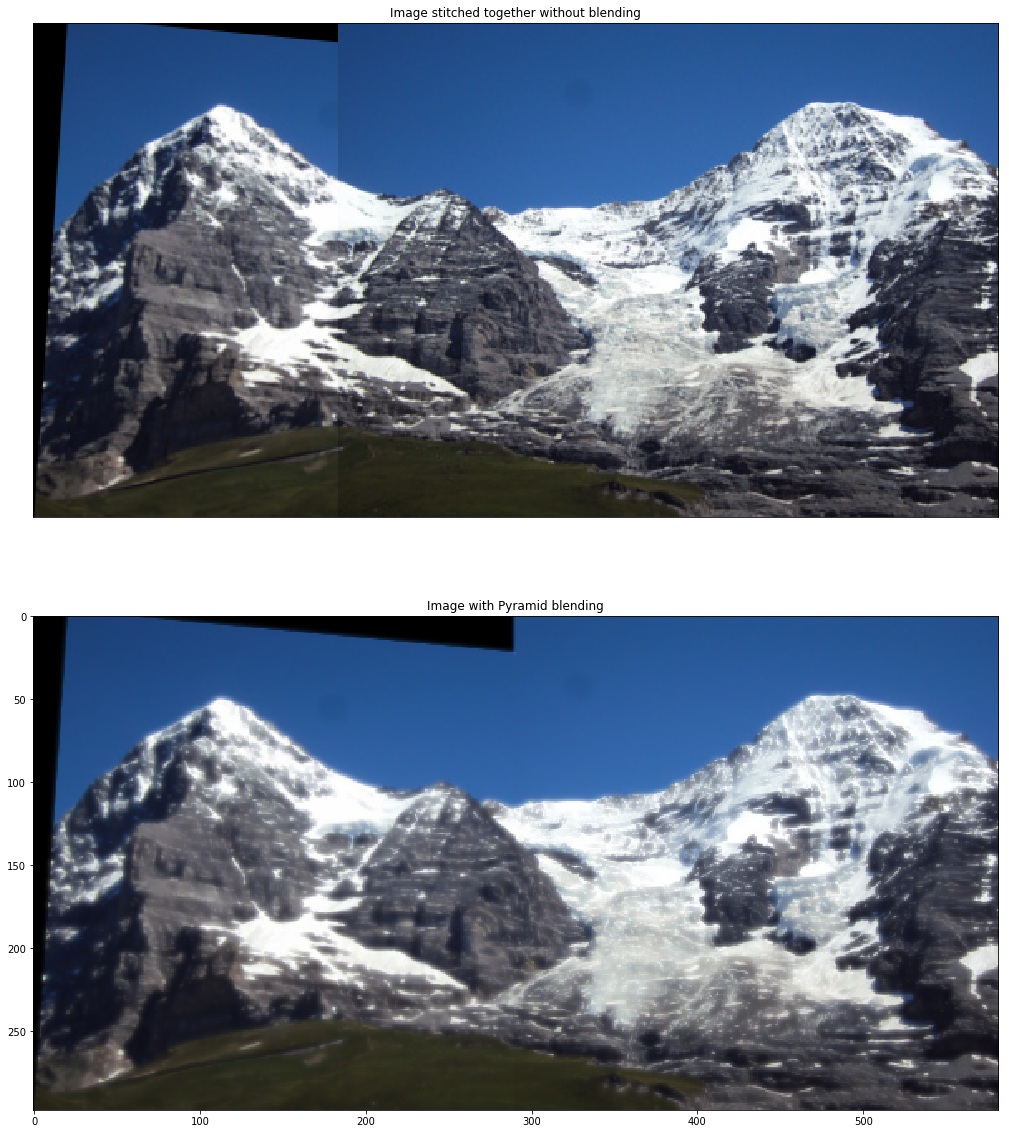

In [11]:
# Pyramid blend images together

import cv2
import numpy as np
import matplotlib.pyplot as plt

# First copy images not to overwrite.
imgHillLeft = appendImage.copy()
imgHillRight = img2Hill.copy()

g_size = 255  # gaussian mask blur size
depth = 2  # pyramid depth size

# Need to trim two images to remove extra black space.
# Define function trim() to do this
# returns x,y,w,h of bounding box of image
def trim(img):
    greyImg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(greyImg, 0, 255, cv2.THRESH_BINARY)
    return cv2.boundingRect(thresh)

# Trim images to the left, to remove extra pixels after warp.
trimVal= trim(imgHillLeft)[0]

imgHillLeft = imgHillLeft[:,trimVal:]
add = np.zeros((imgHillRight.shape), np.uint8)
imgHillRight = np.hstack((add,imgHillRight))
imgHillRight = imgHillRight[:,trimVal:]
warpedImage = warpedImage[:,trimVal:]



# Define size of image, which is size of appended image
row, col, dpt = warpedImage.shape

# Calculate Gaussian pyramids
#gpLeft = GaussianPyramid(imgHillLeft, depth)
G = imgHillLeft.copy()
gpLeft = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gpLeft.append(G)
    
#gpRight = GaussianPyramid(imgHillRight, depth)
G = imgHillRight.copy()
gpRight = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gpRight.append(G)

# Calculate Laplacian Pyramids
#lpLeft = LaplacianPyramid(gpLeft)
lpLeft = [gpLeft[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gpLeft[i], dstsize=(gpLeft[i-1].shape[1], gpLeft[i-1].shape[0]))
    lp = cv2.subtract(gpLeft[i-1], hr, cv2.CV_32F)  # subtract different levels
    lpLeft.append(lp)
        
#lpRight = LaplacianPyramid(gpRight)
lpRight = [gpRight[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gpRight[i], dstsize=(gpRight[i-1].shape[1], gpRight[i-1].shape[0]))
    lp = cv2.subtract(gpRight[i-1], hr, cv2.CV_32F)  # subtract different levels
    lpRight.append(lp)

# add left and right halves of images in each level
mtnPyramid = []
for lapA, lapB in zip(lpLeft, lpRight):
    row, cols, ch = lapA.shape
    # stack columns (half and half)
    lap = np.hstack((lapA[:, 0:int(cols/2)], lapB[:, int(cols/2):]))
    mtnPyramid.append(lap)


# Reconstruct mountain from laplacian pyramid 


reconstruct = mtnPyramid[0]
for i in range(1, depth):
    size = (mtnPyramid[i].shape[1],mtnPyramid[i].shape[0])
    reconstruct = cv2.pyrUp(reconstruct, dstsize = size)
    reconstruct = cv2.add(mtnPyramid[i], reconstruct)
    
# display images
plt.figure(figsize=(20,20))
plt.subplot(211)
plt.imshow(warpedImage)
plt.title("Image stitched together without blending")
plt.xticks([]),plt.yticks([])
plt.subplot(212)
plt.imshow(reconstruct)
plt.title("Image with Pyramid blending")
plt.show()


Let's call the above resulting image 12Hill. Implement the following steps
to stitch 12Hill and 3Hill.
2.2.1. Compute SURF keypoints and corresponding descriptors for images 12Hill
and 3Hill. (3 points)

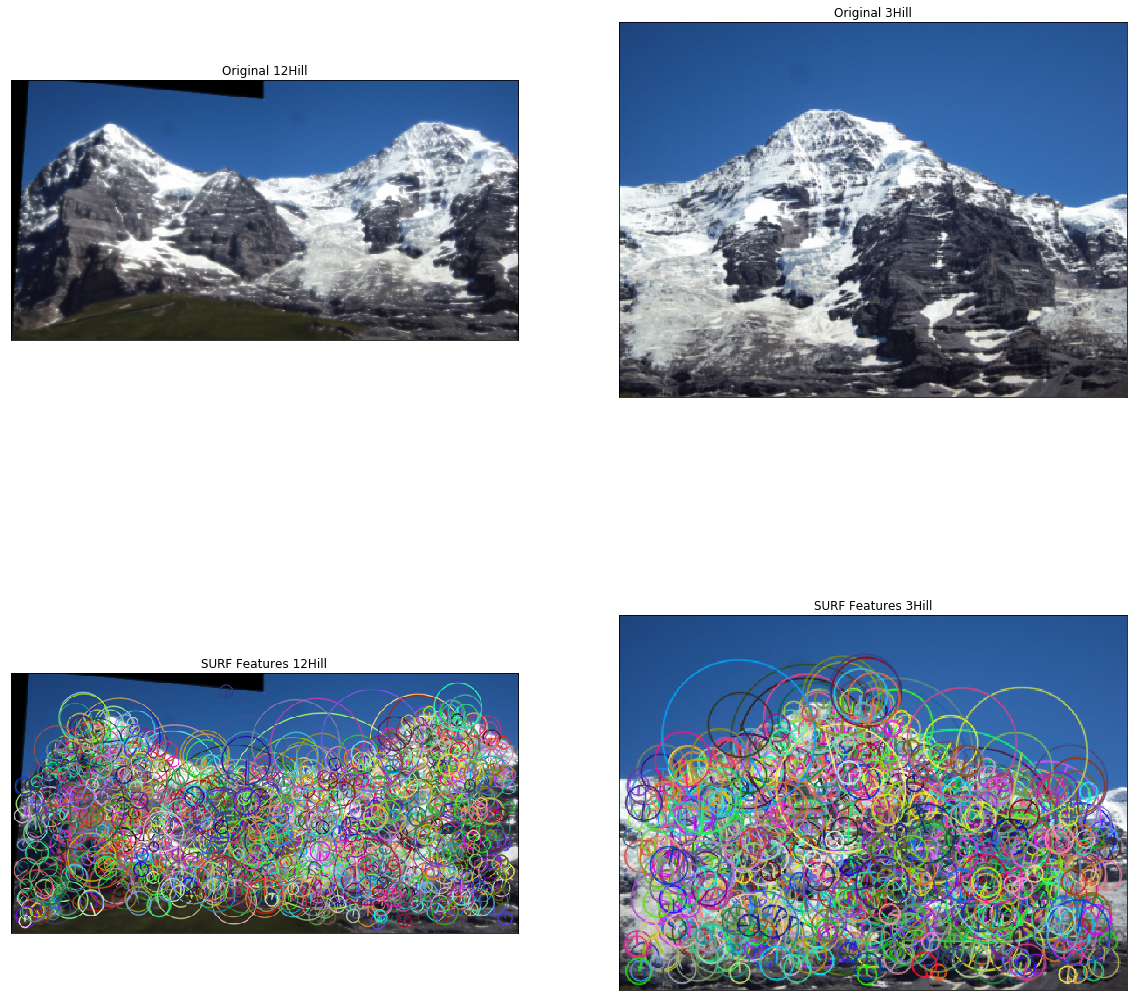

SURF image 1: 0.09973335266113281
SURF image 2: 0.06781816482543945
Number of features 1: 1175
Number of features 2: 850


In [17]:
img12Hill = reconstruct.copy()
img3Hill = img3Hill.copy()

# Trim image img3Hill to remove white border of 1 pixel on edge
img3Hill = img3Hill[1:img3Hill.shape[0]-1,1:img3Hill.shape[1]]

# Convert images to greyscale
gray12Hill = cv2.cvtColor(img12Hill, cv2.COLOR_RGB2GRAY)
gray3Hill = cv2.cvtColor(img3Hill,cv2.COLOR_RGB2GRAY)

# Create SURF object
surf = cv2.xfeatures2d.SURF_create()


# Compute surf keypoints and descriptors on greyscale images of 12Hill and 3Hill
t0 = time.time()
kpts12Hill, desc12Hill = surf.detectAndCompute(gray12Hill, None)
t1 = time.time()
kpts3Hill, desc3Hill = surf.detectAndCompute(gray3Hill, None)
t2 = time.time()

# Draw the keypoints on the images in color
img12Hill_disp = img12Hill.copy()
img3Hill_disp = img3Hill.copy()

# Draw SURF keypoints on images.
cv2.drawKeypoints(img12Hill,kpts12Hill,img12Hill_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.drawKeypoints(img3Hill,kpts3Hill,img3Hill_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#Display Images
imgArr = [img12Hill,img3Hill,img12Hill_disp, img3Hill_disp]
titleArr = ["Original 12Hill","Original 3Hill", "SURF Features 12Hill", "SURF Features 3Hill"]

plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(imgArr[i])
    plt.title(titleArr[i])
    plt.xticks([]), plt.yticks([])
    
plt.show()

print("SURF image 1:", t1-t0)
print("SURF image 2:", t2-t1)
print("Number of features 1:", str(len(kpts12Hill)))
print("Number of features 2:", str(len(kpts3Hill)))

2.2.2 Find matching keypoints in two images and display the 20 best pairs. (4
points)

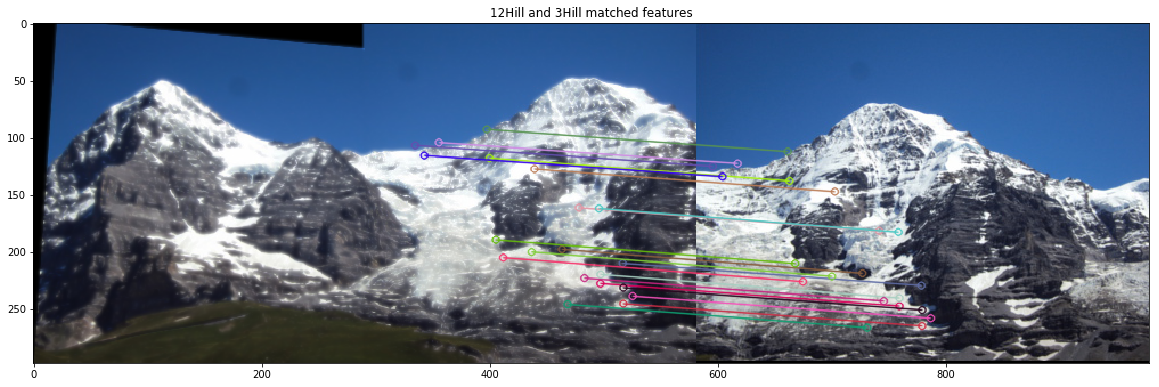

In [13]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
# Copy images to keep above variables unchanged

img12HillLeft = img12Hill.copy()
img3HillRight = img3Hill.copy()

# Compute matches
surfMatches = bf.match(desc12Hill,desc3Hill)
# Sort ascending
surfMatches = sorted(surfMatches, key= lambda x:x.distance)

# Draw top 20 matches on images.
imgDisplay = cv2.drawMatches(img12HillLeft, kpts12Hill, img3HillRight, kpts3Hill, surfMatches[:20],img12HillLeft,flags=2)

plt.figure(figsize=(20,20))
plt.imshow(imgDisplay)
plt.title("12Hill and 3Hill matched features")
plt.show()


2.2.3 Find homography using RANSAC method and apply transformation to
3Hill. Image 12Hill should not be transformed. (7 points)

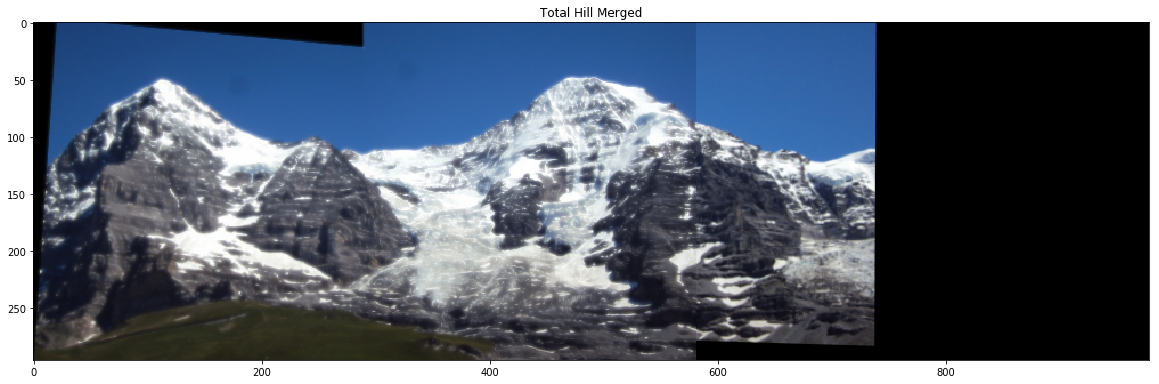

In [14]:
# Arrange matching keypoints in two separate lists
mtnMatches = []
for i, m in enumerate(surfMatches):
    mtnMatches.append((m.trainIdx, m.queryIdx))

matchPointsLeft = np.float32([kpts12Hill[i].pt for (__, i) in mtnMatches])
matchPointsRight = np.float32([kpts3Hill[i].pt for (i, __) in mtnMatches])

# Find homography of two images
Homography123, suh = cv2.findHomography(matchPointsRight,matchPointsLeft, cv2.RANSAC,4)
# Compute warping of img3Hill
warp3Hill = cv2.warpPerspective(img3Hill, Homography123, (img12Hill.shape[1]+img3Hill.shape[1],img3Hill.shape[0]))
warp3Hill_disp = warp3Hill.copy()

# must modify height of img12Hill to allow warp to fit, create array of 0's
#img12Hill = np.zeros((img12Hill.shape[0],img12Hill.shape[1]+img3Hill.shape[1],3), dtype=np.uint8)
img12HillFinal = img12Hill[:img12Hill.shape[0]-2,:]

warp3Hill[:,:img12Hill.shape[1],:] = img12HillFinal

plt.figure(figsize=(20,20))
plt.imshow(warp3Hill)
plt.title("Total Hill Merged")
plt.show()


2.2.4. Stitch transformed 3Hill and 12Hill together and apply linear image
blending. (4 points)

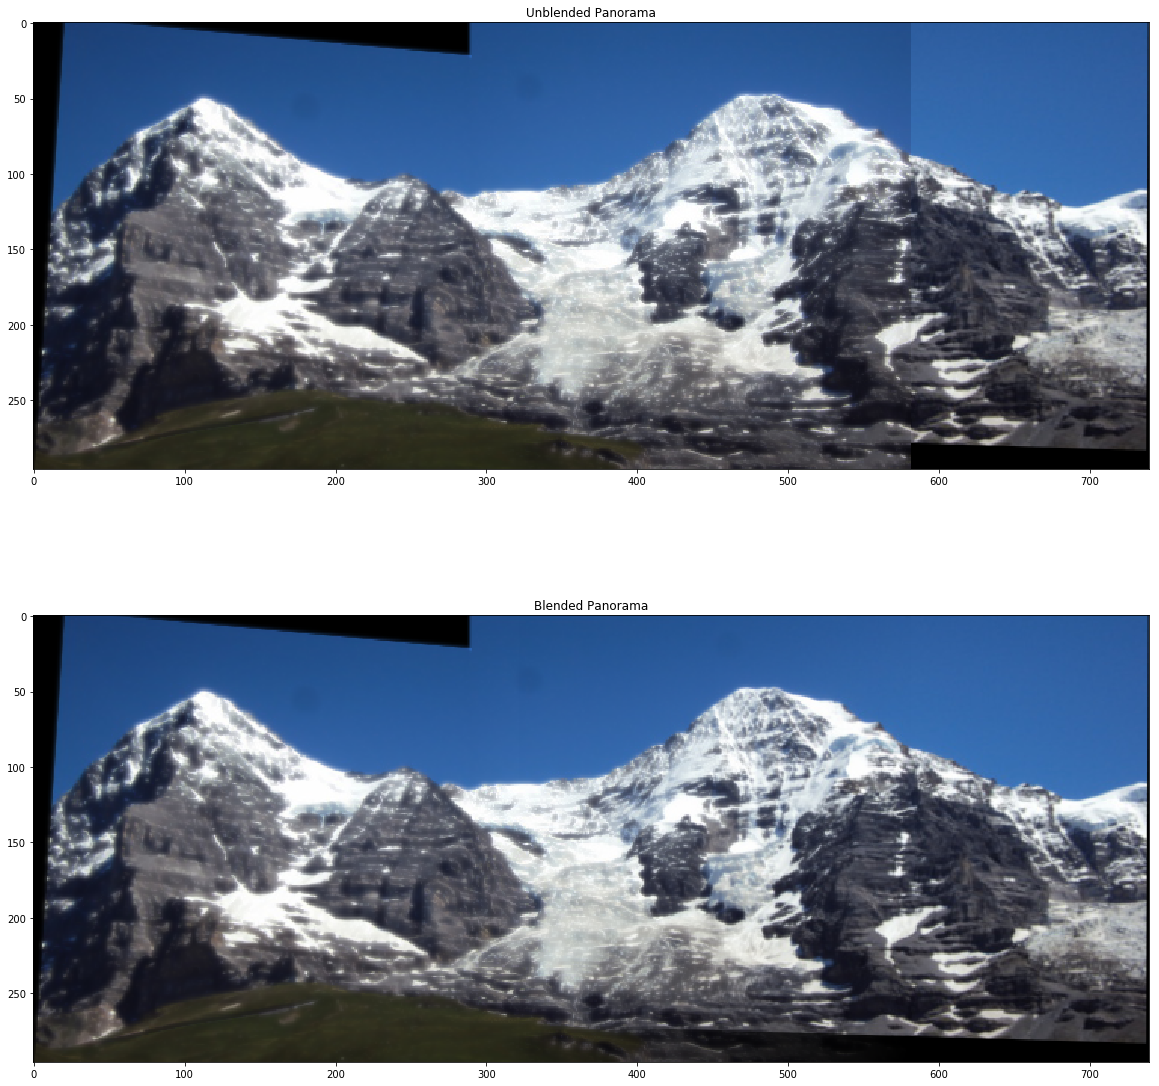

In [15]:
# Copy images from previous code

imgBlendLeft = img12HillFinal.copy()
imgBlendRight = warp3Hill_disp.copy()
imgPanoramaUnblended = warp3Hill.copy()

# First, crop panoramic image and hill3Warp
trimRight= trim(imgPanoramaUnblended)[2]
imgPanoramaUnblended = imgPanoramaUnblended[:,:trimRight]
xStart,__,trimRight2,__ = trim(imgBlendRight)
imgBlendRightTrim = imgBlendRight[:,:xStart+trimRight2]

# Make 12Hill correct size to allow bitwise and
img12HillNew = np.zeros(imgPanoramaUnblended.shape)
for y in range (imgBlendLeft.shape[0]):
    for x in range(imgBlendLeft.shape[1]):
        img12HillNew[y][x] = imgBlendLeft[y][x]
        
# Convert to 8 bit
img12HillNew = np.uint8(img12HillNew)

# Apply blend manually
# For pixels in merged image, apply linear blend
# Define values for ramp

# Find intersection zone of two images
imgALeft = cv2.cvtColor(img12HillNew,cv2.COLOR_RGB2GRAY)
imgBLeft = cv2.cvtColor(imgBlendRightTrim,cv2.COLOR_RGB2GRAY)
imgLeftGrey = cv2.threshold(imgALeft,0,255,cv2.THRESH_BINARY)[1]
imgRightGrey = cv2.threshold(imgBLeft,0,255, cv2.THRESH_BINARY)[1]
intersection = cv2.bitwise_and(imgLeftGrey,imgRightGrey)
inter_start_x,inter_start_y,inter_width_x,inter_height_y = cv2.boundingRect(intersection)

ramp_size = inter_width_x
ramp_center = inter_start_x + 30 + inter_width_x/2
ramp_start = inter_start_x
ramp_end = inter_start_x+ramp_size

# Define empty array in which blended image will be put
imgPanoramaBlended = np.zeros((imgPanoramaUnblended.shape[0],imgPanoramaUnblended.shape[1],3))

for y in range(imgPanoramaBlended.shape[0]):
    for x in range(imgPanoramaBlended.shape[1]):
        # If incrementor is not within ramp area
        if((x < ramp_start)):
            imgPanoramaBlended[y][x] = img12HillNew[y][x]
        # If incrementor is within ramp zone
        elif(x >= ramp_start and x <= ramp_end):
            # Define proportionality factor which weighs how much pixel is worth
            prop = (abs(x-ramp_start))/ramp_size
            imgPanoramaBlended[y][x] = (1-prop) * img12HillNew[y][x] + (prop) * imgBlendRightTrim[y][x]
        elif(x > ramp_end):
            imgPanoramaBlended[y][x] = imgBlendRightTrim[y][x]

# convert back to uint8
imgPanoramaBlended = np.uint8(imgPanoramaBlended) 

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.imshow(imgPanoramaUnblended)
plt.title("Unblended Panorama")
plt.subplot(2,1,2)
plt.imshow(imgPanoramaBlended)
plt.title("Blended Panorama")
plt.show()


### 2.2 Reasoning Questions

2.2.1. What are the differences between SIFT and SURF? Comment on the
speed, number of keypoints and density. Support your arguments with
statistics. (4 points)

There are multiple differences between SIFT and SURF features, the main one being that SURF was designed as a speeded up version of SIFT.

By observing the results of both computations in my code above, it is not obvious that SURF is faster than SIFT, with SIFT taking on approximately 0.055 seconds to compute descriptors, and SURF taking 0.099 and 0.068 secondsto do the same. However, this difference in time may be due to the fact that I am using "detectAndCompute()" to simplify my code, instead of only "detect()". Also, this difference of time may be due to the fact that I am running these tests on my personal computer.

It is also possible to observe the difference in the amount of keypoints. As SIFT is designed to be more thorough, it finds 1248 features on 1Hill, and 1456 features on 2Hill. Comparing this to SURF, SURF found 1175 features on 12Hill and 850 on 3Hill. 12Hill is approximately twice the size of the original image, being the merge between 1Hill and 2Hill, and 3Hill being approximately the same size as 1Hill and 2Hill. Such, it is possible to claim that SIFT finds more keypoints than SURF.

This matches with the theory seen in class, which states that SIFT uses the entire Hessian matrix, whereas SURF uses the determinant of the Hessian matrix, called the Fast-Hessian.

2.2.2. Discuss at least two pros and cons of pyramid and linear blending tech-
niques. When should one prefer pyramid blending over linear blending?
(4 points)

Pros of Linear Blending
* Much simpler to implement: Simply ramp the weighting of each image over the intersection area, progressively changing the values of the pixels and the transition passes from one image to the other, ideally seamlessly blending them.

Cons of Linear Blending
* As it is much simpler, it also performs less well. For example, you can see in certain portions of the uncropped image above that some ghosting is present, as heavily packed features are blended into areas which have less features
* Also, as the filter is only applied to certain portions of the image, i.e. where they intersect, there can often be seen an overall disparity in the colors of the image, such that the blue of the sky, for example, is not constant across the entire sky.
* The weighting of the blending is uniform for all positions in y for example. This can drown out high frequency edges.

Pros of Pyramid Blending
* Pyramid blending results in a smoother blending of the overall image, as the gaussian filter is applied to the entire image. This results in an overall more smooth result.
* It is more efficient at higher frequency smoothing, as the blending is not uniform at all levels like in the linear blending. This means that it is better at retaining edges in the original image

Cons of Pyramid Blending
* Pyramid blending blurs the image multiple times, and reconstructs an image from the successively blurred levels. This means that visually, the image can look more blown out and smoothed, as can be observed in my results above

One would prefer pyramid blending over linear blending when lighting is not uniform across the images that need to be stitched. As explained above, Pyramid blending is applied uniformly across the image, which would remove that change in color across the scene.

Linear blending should be used if a change in lighting is not observable.

2.2.3. What would happen if a random subset of pairs of matching keypoints is
used for finding homography? (2 points)

If a random subset of matching keypoints were to be chosen, a number of different outcomes could occur. As SIFT and SURF features have a measure of confidence in them by the scale of the feature. Essentially, when we sort the features above, we are choosing the features where we have to most confidence in. If a random subset of matching keypoints were to be chosen, then perhaps the confidence in certain keypoints would be less and the features do not actually match on both images, a false positive. 
This situation would then carry on to the computation of the homography matrix, which is used to compute the warp, pan, rotation and scale of the image which must be merged. If two features do not match, then the "warp" function which uses the Homography matrix would incorrectly warp the image.

2.2.4. Discuss the relationship between the number of pairs of matching key-
points used for finding homography and the accuracy of inferred homog-
raphy. (2 points)

As explained above, this reliability is dependant on the confidence of the keypoints. However, if more confident keypoints are used, then the accuracy of the homography will increase. This is due to a larger amount of sample points on which to base the homography matrix, which will then modify and move the pixels close to those keypoints in a similar manner. Such, if more keypoints are used, the image is more reliably warped.
However, this reliablility is based on the assumption that the keypoints are reliable keypoints. If more keypoints are used, but includes lower confidence keypoints, the Homography matrix will not be more accurate, as some keypoints may be erroneous.